In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

# CSV overview (DATD train & DATD test)

In [2]:
test = pd.read_csv('datd_test.csv')
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 2 columns


In [3]:
test.head(5)

,text,label
0,"Aku merindukan tempatku yang tenang, tanpa ras...",1
1,Gelisah tanpa sebab. Terasa seperti punya kein...,1
2,"Sekarang kita masih sama, suka bingung. Suka c...",0
3,"aku mula lah gelisah bila dia outstation , kal...",0
4,"Kasihan kamu, hidup dalam tekanan dan selalu d...",0


In [4]:
train = pd.read_csv('datd_train.csv')
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 900 rows and 2 columns


In [5]:
train.head(5)

,text,label
0,abis minum kopi perasaan mesti gelisah gatau k...,0
1,sumpah ya dari pagi rasanya gelisah terus,1
2,Catia hari sabtu.Presntasi Statin hari sabtu.....,1
3,tbtb gelisah 🤕,0
4,Memasuki jam jam rawan... Seliweran mulu di ga...,0


# Text Preprocessing

In [6]:
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"# flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
def process(text):
  # remove links
  text = re.sub("https://t.co/\S*","",text) 

  # remove newline
  text = re.sub("\n","",text)

  # remove digits
  text = re.sub("[0-9]","",text)

  # remove emojis
  text = deEmojify(text)

  return text

## Cleaning Train

In [8]:
train_corpus = list(map(process, train['text']))    
print(len(train_corpus))
print(train_corpus[1])

900
sumpah ya dari pagi rasanya gelisah terus


## Cleaning test

In [9]:
test_corpus = list(map(process, test['text']))    
print(len(test_corpus))
print(test_corpus[1])

100
Gelisah tanpa sebab. Terasa seperti punya keinginan melakukan sesuatu namun terhalang oleh sesuatu.


# Bagi Test Set dan Train Set

In [10]:
X_train = train_corpus
y_train = train['label'].tolist()

X_test = test_corpus
y_test = test['label'].tolist()

In [11]:
print(len(X_train[0]))
print(X_train[0])
print(len(X_train))
print(len(y_train))

137
abis minum kopi perasaan mesti gelisah gatau knapa, tp tiap kali dibuat nonton vidio yg sedih sedih gampang bgt nangisnya, jd lebih lega 
900
900


# Building models

In [12]:
VOCAB_SIZE = 4000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

## Model 1 (LSTM)

In [19]:
model_lstm = Sequential()
model_lstm.add(encoder)
model_lstm.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])

history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

Epoch 1/30
15/15 [==============================] - 8s 167ms/step - loss: 0.6904 - accuracy: 0.5449 - recall: 0.0706 - val_loss: 0.6510 - val_accuracy: 0.6800 - val_recall: 0.0000e+00
Epoch 2/30
15/15 [==============================] - 1s 59ms/step - loss: 0.6557 - accuracy: 0.5943 - recall: 0.0000e+00 - val_loss: 0.5950 - val_accuracy: 0.6800 - val_recall: 0.0000e+00
Epoch 3/30
15/15 [==============================] - 1s 61ms/step - loss: 0.5982 - accuracy: 0.6657 - recall: 0.2331 - val_loss: 0.5438 - val_accuracy: 0.7800 - val_recall: 0.4062
Epoch 4/30
15/15 [==============================] - 1s 63ms/step - loss: 0.4405 - accuracy: 0.8529 - recall: 0.6901 - val_loss: 0.6177 - val_accuracy: 0.6800 - val_recall: 0.7500
Epoch 5/30
15/15 [==============================] - 1s 62ms/step - loss: 0.2650 - accuracy: 0.9216 - recall: 0.9265 - val_loss: 0.6649 - val_accuracy: 0.7500 - val_recall: 0.6562
Epoch 6/30
15/15 [==============================] - 1s 62ms/step - loss: 0.1746 - accuracy: 

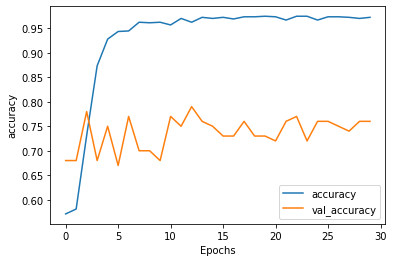

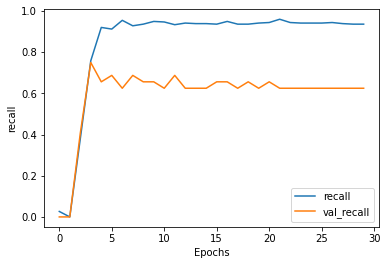

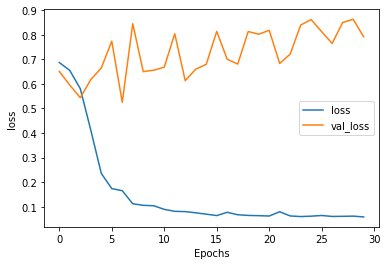

In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'recall')
plot_graphs(history, 'loss')

In [24]:
rand = pd.read_csv('datd_rand.csv')
X_rand = list(map(process, rand['text']))
y_rand = rand['label'].tolist()

def evaluate_on_rand(y_predict):
  tp = 0
  tn = 0
  fn = 0
  fp = 0
  for k, v in enumerate(y_predict):
    predict = int(np.round(v))
    actual = y_rand[k]

    if actual and not predict:
      fn += 1
    
    if actual and predict:
      tp += 1

    if not actual and predict:
      fp += 1

    if not actual and not predict:
      tn += 1

  print('accuracy:', (tp+tn)/len(y_predict))
  print('precision:', tp/(tp+fp))
  print('recall:', tp/(tp+fn))
  print('f1:', (2*tp)/(2*tp + fp+ fn))

evaluate_on_rand(model_lstm.predict(X_rand))

accuracy: 0.7844011142061281
precision: 0.3206865401987353
recall: 0.9416445623342176
f1: 0.4784366576819407


## Model 2 (Bidirectional)

In [44]:
model_bilstm = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=100, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history = model_bilstm.fit(train['text'], train['label'], validation_data=(test['text'], test['label']), epochs=15, batch_size=64)

Epoch 1/15
15/15 [==============================] - 16s 298ms/step - loss: 0.6875 - accuracy: 0.5896 - recall_5: 0.1670 - val_loss: 0.6044 - val_accuracy: 0.6800 - val_recall_5: 0.0000e+00
Epoch 2/15
15/15 [==============================] - 2s 104ms/step - loss: 0.6380 - accuracy: 0.5943 - recall_5: 0.0102 - val_loss: 0.5411 - val_accuracy: 0.7800 - val_recall_5: 0.3438
Epoch 3/15
15/15 [==============================] - 2s 105ms/step - loss: 0.5143 - accuracy: 0.8150 - recall_5: 0.5899 - val_loss: 0.5128 - val_accuracy: 0.8100 - val_recall_5: 0.6562
Epoch 4/15
15/15 [==============================] - 2s 104ms/step - loss: 0.3020 - accuracy: 0.9110 - recall_5: 0.9364 - val_loss: 0.8138 - val_accuracy: 0.7500 - val_recall_5: 0.5938
Epoch 5/15
15/15 [==============================] - 2s 102ms/step - loss: 0.1743 - accuracy: 0.9507 - recall_5: 0.9483 - val_loss: 0.4803 - val_accuracy: 0.8100 - val_recall_5: 0.5625
Epoch 6/15
15/15 [==============================] - 2s 108ms/step - loss: 0

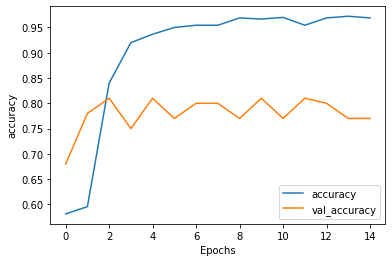

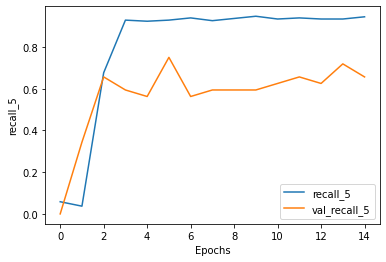

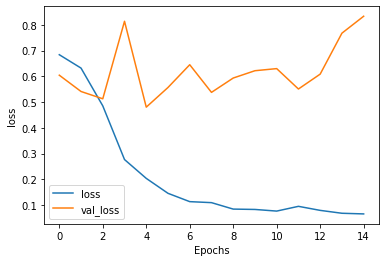

In [45]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'recall_5')
plot_graphs(history, 'loss')

In [47]:
evaluate_on_rand(model_bilstm.predict(X_rand))

accuracy: 0.8607242339832869
precision: 0.4261704681872749
recall: 0.9416445623342176
f1: 0.5867768595041323


In [48]:
model_bilstm.predict(["contoh teks tweet satu",
               "contoh teks tweet dua",
               "contoh teks tweet tiga"])

array([[0.03787252],
       [0.00413013],
       [0.00978747]], dtype=float32)

# Results (DATD+Rand)

Classifier | Accuracy | Precision | Recall | F1
--- | --- | --- | --- | --- 
LSTM | 0.78 | 0.32 | 0.94 | 0.48 |
BI-LSTM | 0.86 | 0.43 | 0.94 | 0.59 |

In [29]:
model_bilstm.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [30]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/variables/variables.index (deflated 66%)
  adding: model/assets/ (stored 0%)
